In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# ------------------------------
# Step 1: Data Loading
# ------------------------------
print("=== Step 1: Data Loading ===")
# Load the dataset
df = pd.read_csv('creditcard.csv') 

# Display basic info
print(f"Dataset Shape: {df.shape}")
print(f"Class Distribution:\n{df['Class'].value_counts(normalize=True)}")
print("\nFirst few rows:")
print(df.head())

=== Step 1: Data Loading ===
Dataset Shape: (265360, 31)
Class Distribution:
Class
0.0    0.998191
1.0    0.001809
Name: proportion, dtype: float64

First few rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -

In [ ]:
# ------------------------------
# Step 2: Data Preprocessing (EDA, Cleaning, Scaling, Feature Engineering)
# ------------------------------
print("\n=== Step 2: Data Preprocessing ===")

# 2.1 Exploratory Data Analysis (Basic)
print("\n--- EDA ---")
print(df.describe())

# Check for missing values
print(f"\nMissing Values:\n{df.isnull().sum()}")

# 2.2 Data Cleaning (Imputation)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 2.3 Feature Engineering (Add derived features)
print("\n--- Feature Engineering ---")
df['Hour'] = (df['Time'] % (24 * 3600)) // 3600  # Extract hour from Time
print("Added 'Hour' feature.")

# 2.4 Feature Scaling & Encoding
print("\n--- Feature Scaling & Encoding ---")
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split into train (70%), validation (10%), test (20%) sets
# Use stratified split to maintain class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.143, random_state=42, stratify=y_train_val) # 0.1 / 0.7 = 0.143

# Initialize scaler
scaler = MinMaxScaler()

# Fit scaler on training data only, then transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"Training set shape after scaling: {X_train_scaled_df.shape}")
print(f"Validation set shape after scaling: {X_val_scaled_df.shape}")
print(f"Test set shape after scaling: {X_test_scaled_df.shape}")


=== Step 2: Data Preprocessing ===

--- EDA ---
                Time             V1             V2             V3  \
count  265360.000000  265360.000000  265360.000000  265360.000000   
mean    89547.470105      -0.015027      -0.015417       0.053004   
std     44872.212760       1.959484       1.659608       1.510432   
min         0.000000     -56.407510     -72.715728     -33.680984   
25%     52001.000000      -0.926028      -0.608306      -0.802689   
50%     80078.000000       0.014492       0.059404       0.246511   
75%    132772.000000       1.288993       0.787219       1.067653   
max    161851.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  265360.000000  265359.000000  265359.000000  265359.000000   
mean        0.012115      -0.021416       0.009235      -0.009290   
std         1.416238       1.370226       1.325277       1.222763   
min        -5.683171     -42.147898     -26.160506   

In [ ]:
# ------------------------------
# Step 3: Imbalance Handling (SMOTE, Undersampling)
# ------------------------------
print("\n=== Step 3: Imbalance Handling ===")

# Define resampling methods
smote = SMOTE(sampling_strategy='auto', random_state=42)
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply SMOTE to training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_df, y_train)
print(f"SMOTE - Original Train Class 1 count: {y_train.sum()}")
print(f"SMOTE - Resampled Train Class 1 count: {y_train_smote.sum()}")

# Apply Undersampling to training data
X_train_under, y_train_under = undersampler.fit_resample(X_train_scaled_df, y_train)
print(f"Undersampling - Original Train Class 1 count: {y_train.sum()}")
print(f"Undersampling - Resampled Train Class 1 count: {y_train_under.sum()}")

# Optional: Hybrid approach (SMOTE + Undersampling)
# create a hybrid using SMOTE followed by RandomUnderSampler
hybrid_pipeline = ImbPipeline([
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)), # Oversample to 50% of majority
    ('undersample', RandomUnderSampler(sampling_strategy='majority', random_state=42)) # Then undersample majority
])
X_train_hybrid, y_train_hybrid = hybrid_pipeline.fit_resample(X_train_scaled_df, y_train)
print(f"Hybrid (SMOTE+Undersample) - Resampled Train Class 1 count: {y_train_hybrid.sum()}")

# For simplicity in initial model comparison
X_train_final = X_train_smote
y_train_final = y_train_smote


=== Step 3: Imbalance Handling ===
SMOTE - Original Train Class 1 count: 329.0
SMOTE - Resampled Train Class 1 count: 181601.0
Undersampling - Original Train Class 1 count: 329.0
Undersampling - Resampled Train Class 1 count: 329.0
Hybrid (SMOTE+Undersample) - Resampled Train Class 1 count: 90800.0


In [ ]:
# ------------------------------
# Step 4: Model Selection & Training
# ------------------------------
print("\n=== Step 4: Model Selection & Training ===")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])),
    'Isolation Forest': None # Isolation Forest is unsupervised, so i have handled it separately
}

# Hyperparameter tuning using GridSearchCV with 5-fold Stratified Cross-Validation
# We define parameter grids for the supervised models
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'n_estimators': [100, 200]
    }
}

# Dictionary to store trained models and their best parameters
trained_models = {}
best_params = {}

# Train and tune each model
for name, model in models.items():
    if name == 'Isolation Forest':
        continue
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='recall',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_final, y_train_final)
    trained_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_
    print(f"Best parameters for {name}: {best_params[name]}")

# Train Isolation Forest (Anomaly Detection)
print("\nTraining Isolation Forest...")
iso_forest = IsolationForest(contamination=0.0017, random_state=42, n_estimators=100) # contamination matches fraud rate
iso_forest.fit(X_train_final)
iso_forest.fit(X_train_scaled_df)
trained_models['Isolation Forest'] = iso_forest
best_params['Isolation Forest'] = {'contamination': 0.0017, 'n_estimators': 100}


=== Step 4: Model Selection & Training ===

Training Logistic Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2'}

Training Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Training XGBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}

Training Isolation Forest...



=== Step 5: Performance Evaluation ===

--- Evaluation for Logistic Regression ---
Precision: 0.0595
Recall: 0.9583
F1-Score: 0.1121
ROC-AUC: 0.9906


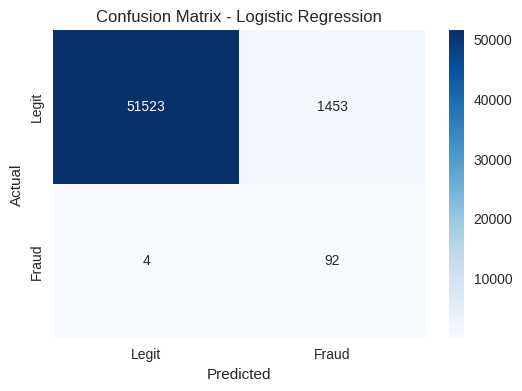

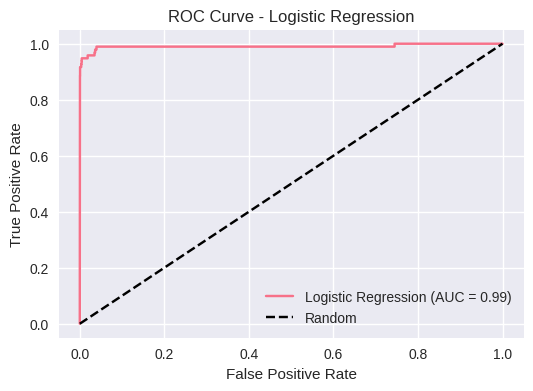


--- Evaluation for Random Forest ---
Precision: 0.8947
Recall: 0.8854
F1-Score: 0.8901
ROC-AUC: 0.9925


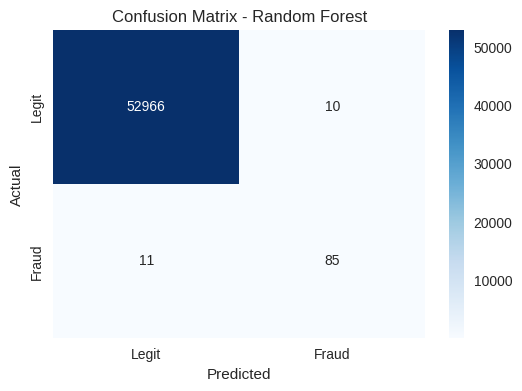

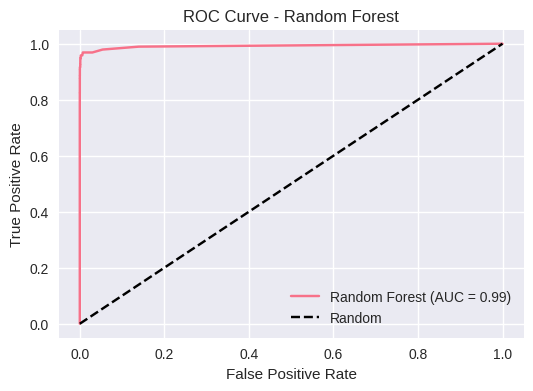


--- Evaluation for XGBoost ---
Precision: 0.0027
Recall: 1.0000
F1-Score: 0.0054
ROC-AUC: 0.9582


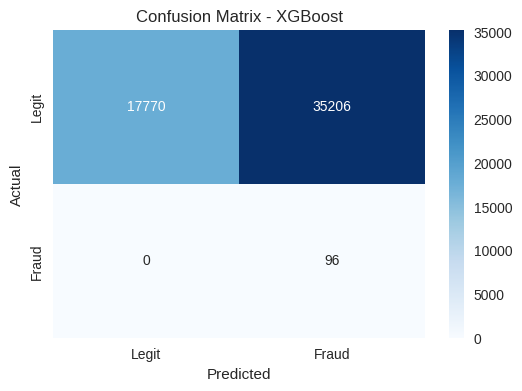

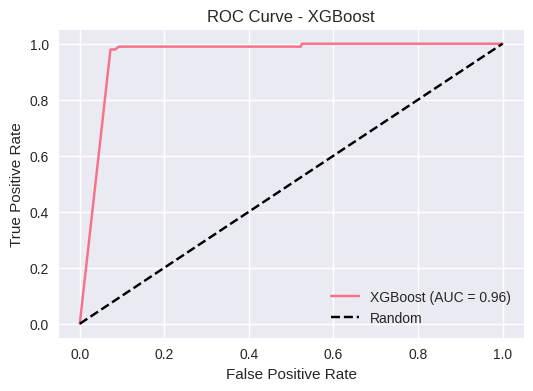


--- Evaluation for Isolation Forest ---
Precision: 0.2542
Recall: 0.3125
F1-Score: 0.2804
ROC-AUC: 0.9680


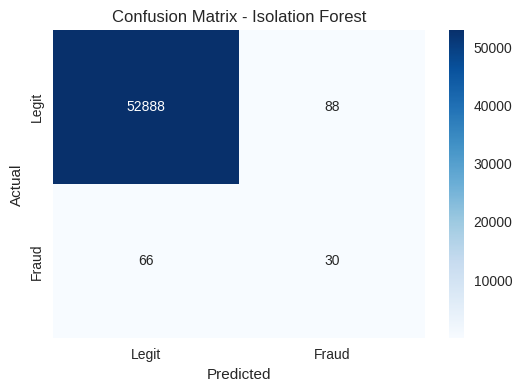

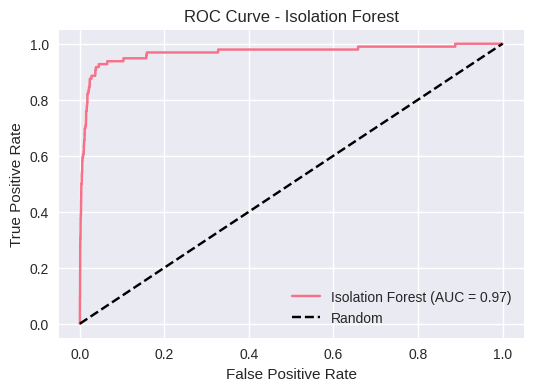

In [ ]:
# ------------------------------
# Step 5: Performance Evaluation
# ------------------------------
print("\n=== Step 5: Performance Evaluation ===")

# Function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n--- Evaluation for {model_name} ---")

    if model_name == 'Isolation Forest':
        # Isolation Forest returns -1 for outliers (fraud), 1 for inliers (normal)
        y_pred_proba = -model.decision_function(X_test)
        y_pred = model.predict(X_test)
        y_pred_binary = np.where(y_pred == -1, 1, 0) # Convert -1/1 to 1/0
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of positive class (fraud)
        y_pred = model.predict(X_test)
        y_pred_binary = y_pred

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_binary)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'model_name': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred_proba': y_pred_proba,
        'y_pred_binary': y_pred_binary
    }

# Evaluate all models
evaluation_results = []
for name, model in trained_models.items():
    result = evaluate_model(model, X_test_scaled_df, y_test, name)
    evaluation_results.append(result)


=== Step 6: Feature Importance Analysis ===


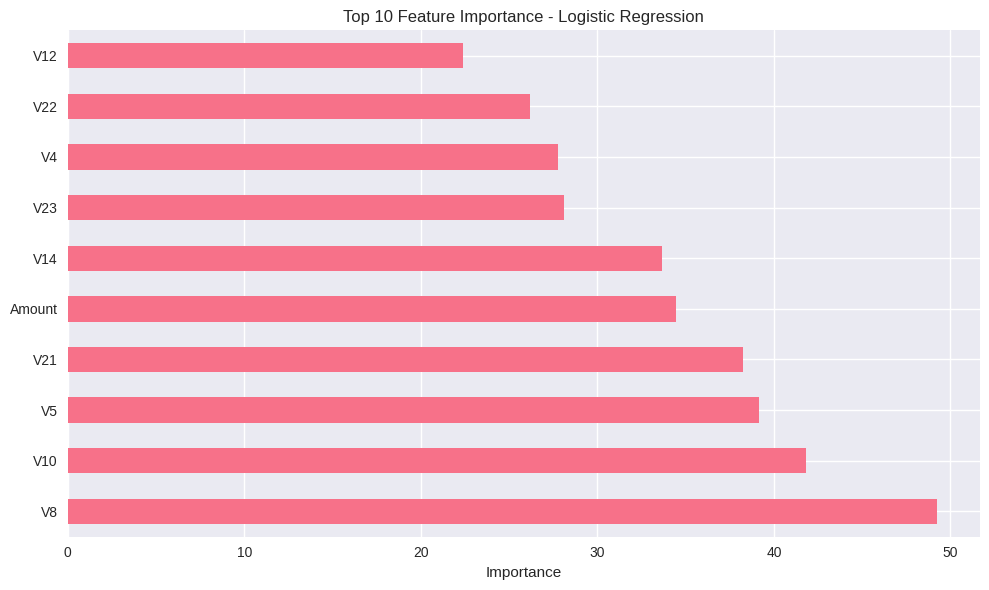

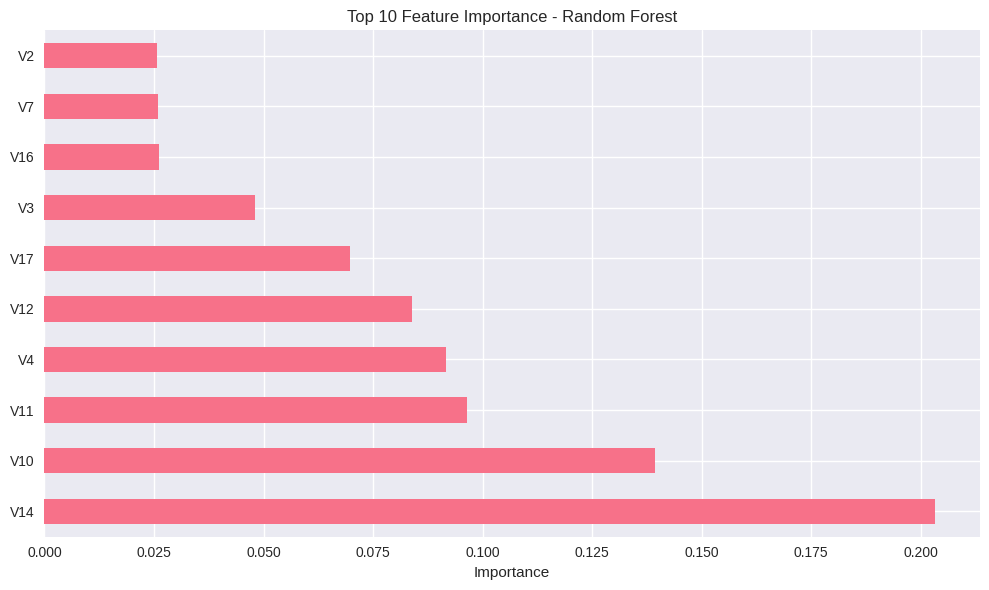

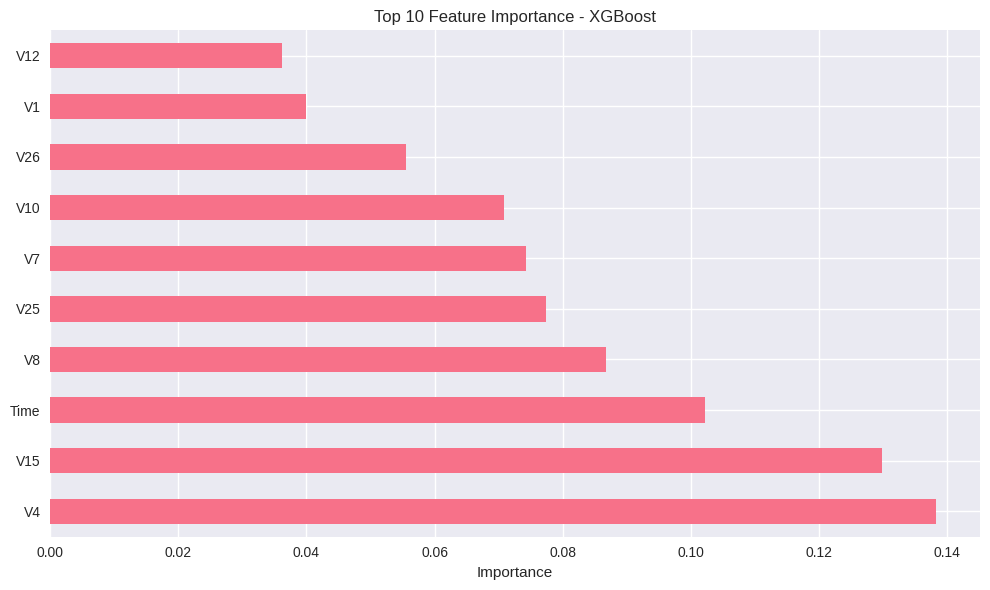

In [ ]:
# ------------------------------
# Step 6: Feature Importance Analysis
# ------------------------------
print("\n=== Step 6: Feature Importance Analysis ===")

# Get feature importance for models that support it
feature_importance = {}

for name, model in trained_models.items():
    if name in ['Logistic Regression', 'Random Forest', 'XGBoost']:
        if name == 'Logistic Regression':
            # Coefficients represent importance (absolute value for magnitude)
            importance = np.abs(model.coef_[0])
        elif name == 'Random Forest':
            importance = model.feature_importances_
        elif name == 'XGBoost':
            importance = model.feature_importances_

        feature_importance[name] = pd.Series(importance, index=X_train_scaled_df.columns).sort_values(ascending=False)

        # Plot
        plt.figure(figsize=(10, 6))
        feature_importance[name][:10].plot(kind='barh') # Top 10 features
        plt.title(f'Top 10 Feature Importance - {name}')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

In [ ]:

# ------------------------------
# Step 7: Model Comparison
# ------------------------------
print("\n=== Step 7: Model Comparison ===")

# Create a summary table
comparison_df = pd.DataFrame(evaluation_results)[['model_name', 'precision', 'recall', 'f1', 'roc_auc']]
print(comparison_df.to_string(index=False))

# Identify best performing model based on recall and ROC-AUC (as per methodology)
best_model_idx = comparison_df[['f1', 'roc_auc']].idxmax().iloc[0] # pick model with highest recall, then AUC
best_model_name = comparison_df.loc[best_model_idx, 'model_name']
best_model = trained_models[best_model_name]

print(f"\nBest Performing Model (based on Recall): {best_model_name}")


=== Step 7: Model Comparison ===
         model_name  precision   recall       f1  roc_auc
Logistic Regression   0.059547 0.958333 0.112127 0.990621
      Random Forest   0.894737 0.885417 0.890052 0.992476
            XGBoost   0.002719 1.000000 0.005424 0.958175
   Isolation Forest   0.254237 0.312500 0.280374 0.968049

Best Performing Model (based on Recall): XGBoost


In [ ]:
# ------------------------------
# Step 8: Automation Pipeline (Basic Structure)
# ------------------------------
print("\n=== Step 8: Automation Pipeline ===")

# Save the best model and scaler for future use (simulates pipeline)
joblib.dump(best_model, 'best_fraud_detection_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
print("Best model and scaler saved.")

# Simulate inference on new data (using test set as example)
print("\nSimulating Inference on Test Set...")
new_data = X_test_scaled_df # New incoming data (already scaled)
predictions = best_model.predict(new_data)
probabilities = best_model.predict_proba(new_data)[:, 1] if hasattr(best_model, 'predict_proba') else None

# If it's Isolation Forest, handle predictions differently
if best_model_name == 'Isolation Forest':
    predictions = np.where(best_model.predict(new_data) == -1, 1, 0)
    probabilities = -best_model.decision_function(new_data) # Higher score = more likely fraud

print(f"Sample Predictions (first 10): {predictions[:10]}")
print(f"Sample Probabilities (first 10): {probabilities[:10] if probabilities is not None else 'N/A'}")


=== Step 8: Automation Pipeline (Basic Structure) ===
Best model and scaler saved.

Simulating Inference on Test Set...
Sample Predictions (first 10): [1 0 1 0 0 1 0 1 1 1]
Sample Probabilities (first 10): [0.95357317 0.2690276  0.95153165 0.2690276  0.33194298 0.74975497
 0.3118953  0.95153165 0.6816664  0.94757473]



=== Step 9: Visualization & Dashboard (Basic Plots) ===


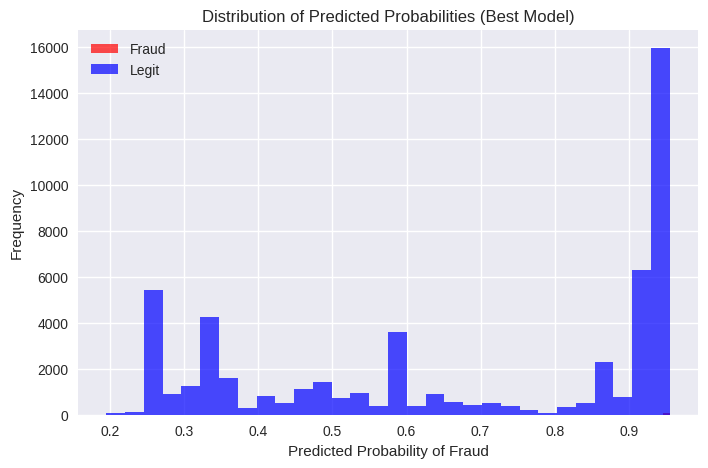


=== Implementation Complete ===
You can now load the saved model ('best_fraud_detection_model.pkl') and scaler ('feature_scaler.pkl') for future predictions.


In [ ]:
# ------------------------------
# Step 9: Visualization & Dashboard (Basic Plots)
# ------------------------------
print("\n=== Step 9: Visualization & Dashboard (Basic Plots) ===")

# Additional Visualization: Histogram of Fraud Probabilities for Best Model
if probabilities is not None:
    plt.figure(figsize=(8, 5))
    plt.hist(probabilities[y_test == 1], bins=30, alpha=0.7, color='red', label='Fraud')
    plt.hist(probabilities[y_test == 0], bins=30, alpha=0.7, color='blue', label='Legit')
    plt.xlabel('Predicted Probability of Fraud')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities (Best Model)')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n=== Implementation Complete ===")
print("loaded the saved model ('best_fraud_detection_model.pkl') and scaler ('feature_scaler.pkl') for future predictions.")